# Forecasting the monthly sales of French champagne

## TO-DO

* Give a detailed explanation for each step
* Fix x axis on line plot
* Replace TimeGrouper for Grouper(freq=..) (currently having problems with Grouper)
* Additional data exploration
* Train a time window based Multilayer Perceptron and compare to ARIMA

Before we use ARIMA to model our dataset, let's start by making a naive forecast using walk-forward validation since we want to have a baseline model:

In [115]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
from sklearn.metrics import mean_squared_error
import statsmodels as stmd
from math import sqrt

def parser(dates):
    return pd.datetime.strptime(dates, '%Y-%m')

series = pd.read_csv('monthly-champagne-sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
# print(series)
dataset, validation = series[0:-12], series[-12:] #test set is the final year
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

# load data
series = pd.read_csv('dataset.csv', index_col=0, header=0, squeeze=True)
print(series)

# preparing data
X = series.values
# print(X)
X = X.astype('float32')
train_size = int(len(X) * 0.5)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
#     print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

Month
1964-01-01     2815
1964-02-01     2672
1964-03-01     2755
1964-04-01     2721
1964-05-01     2946
1964-06-01     3036
1964-07-01     2282
1964-08-01     2212
1964-09-01     2922
1964-10-01     4301
1964-11-01     5764
1964-12-01     7312
1965-01-01     2541
1965-02-01     2475
1965-03-01     3031
1965-04-01     3266
1965-05-01     3776
1965-06-01     3230
1965-07-01     3028
1965-08-01     1759
1965-09-01     3595
1965-10-01     4474
1965-11-01     6838
1965-12-01     8357
1966-01-01     3113
1966-02-01     3006
1966-03-01     4047
1966-04-01     3523
1966-05-01     3937
1966-06-01     3986
              ...  
1969-04-01     4276
1969-05-01     4968
1969-06-01     4677
1969-07-01     3523
1969-08-01     1821
1969-09-01     5222
1969-10-01     6872
1969-11-01    10803
1969-12-01    13916
1970-01-01     2639
1970-02-01     2899
1970-03-01     3370
1970-04-01     3740
1970-05-01     2927
1970-06-01     3986
1970-07-01     4217
1970-08-01     1738
1970-09-01     5221
1970-10-01    

# Data Analysis

## Summary statistics

In [116]:
print(series.describe())

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: Perrin Freres monthly champagne sales millions ?64-?72, dtype: float64


## Line plot of time series

Let's look at the monthly sales of Perrin Freres champagne (excluding the data from the validation set):

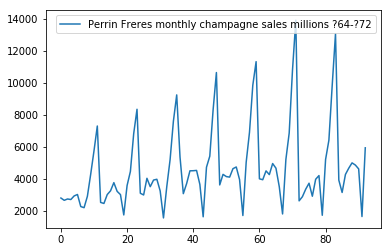

In [143]:
series = pd.read_csv('dataset.csv', header=0, squeeze=True)
series.plot()
plt.show()

It seems there is a seasonality in this time series. *need to fix x-axis

## Box and Whisker Plots

/Users/jacquesthibodeau/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  app.launch_new_instance()


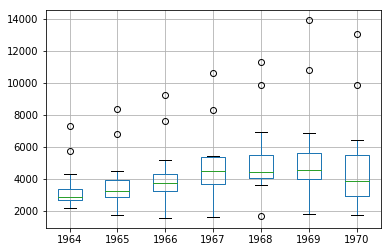

In [127]:
series = pd.read_csv('dataset.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
# print(series)
groups = series['1964':'1970'].groupby(pd.TimeGrouper('A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

# ARIMA

In order to use ARIMA, we need to make sure we are working with a stationary time series. This is not the case, so we need to difference the series. We'll be differencing the series by substracting the observation from the same time in the previous cycle since it seems like the seasonality is year-to-year. We will lose the first year because it has no prior year to be differenced with, but it is a small price to pay.

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


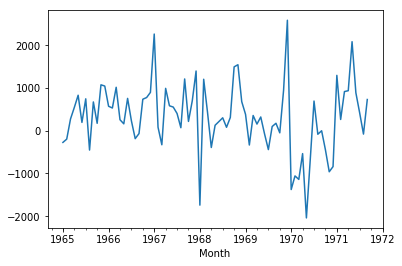

In [138]:
from statsmodels.tsa.stattools import adfuller

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

series = pd.read_csv('dataset.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
X = series.values
X = X.astype('float32')

# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[month_in_year:]
# print(stationary)

# check if stationary
# Dickey-Fuller test for statistical significance
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
plt.show()

Our time series is now stationary. Before we use ARIMA, we need to select the lag values for the Autoregression (p) and Moving Average (q) parameters. With the help of the Autocorrelation Function and the Partial Autocorrelation Function plots, we can get a good starting point.

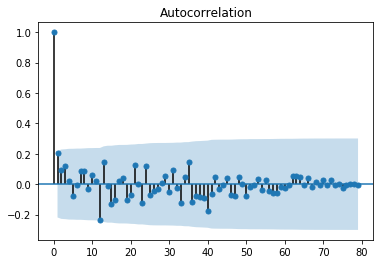

In [158]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

series = pd.read_csv('stationary.csv', header=0, parse_dates=[0], index_col=0)
plot_acf(series, ax=plt.gca())
plt.show()

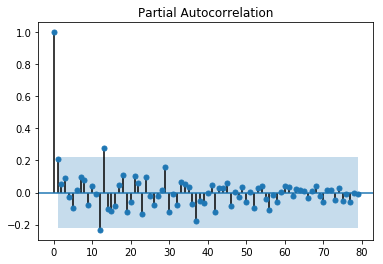

In [159]:
plot_pacf(series, ax=plt.gca())

Both figures show significant lag for 1 month. PACF also has some lag at 12 and 13 that might be significant.

### ARIMA Model

In [164]:
from statsmodels.tsa.arima_model import ARIMA

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = pd.read_csv('dataset.csv', index_col=0, header=0, squeeze=True)
# print(series)

# preparing data
X = series.values
# print(X)
X = X.astype('float32')
train_size = int(len(X) * 0.5)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
#     print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 939.464
